In [359]:
from plyfile import PlyData, PlyElement
import matplotlib.pyplot as plt
import numpy as np
from functools import cmp_to_key

In [360]:
p0 = {'x':0, 'y':0}

In [361]:
def plot_ply(points, edges):
    
    edges.append(edges[0])
    #print(edges)
    
    x = [ sub['x'] for sub in points ]
    y = [ sub['y'] for sub in points ]
    
    edge_x = [ sub['x'] for sub in edges ]
    edge_y = [ sub['y'] for sub in edges ]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(x, y, c='r', marker='o')
    ax.plot(edge_x,edge_y)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    plt.show()

In [362]:
def distance(p1, p2):
    return ((p1['x'] - p2['x']) * (p1['x'] - p2['x']) + (p1['y'] - p2['y']) * (p1['y'] - p2['y']))

In [363]:
def orientation(p, q, r):
    val = ((q['y'] - p['y']) * (r['x'] - q['x']) - (q['x'] - p['x']) * (r['y'] - q['y']))
    if val == 0:
        return 0  # collinear
    elif val > 0:
        return 1  # right
    else:
        return 2  # left

def comparator(p1, p2):
    o = orientation(p0, p1, p2)
    if o == 0:
        if distance(p0, p2) >= distance(p0, p1):
            return -1
        else:
            return 1
    else:
        if o == 2:
            return -1
        else:
            return 1

In [364]:
def graham_scan(points):
    n = len(points)
    #print(n)
    ymin = points[0]['y']
    index_min = 0
    
    for i, point in enumerate(points):
        if point['y'] < ymin:
            ymin = point['y']
            index_min = i
        if point['y'] == ymin:
            if point['x'] < points[index_min]['x']:
                index_min = i
    
    #print(points[index_min])
    p0 = points[index_min]
    points[0], points[index_min] = points[index_min], points[0]
    
    '''Sort points by angle'''
    sorted_points = sorted(points[1:], key=cmp_to_key(comparator))
    #print(sorted_points)
    
    '''If 2 points make the same angle with the minimum point, keep only the point that has maximum distance with
    minimum point. Discard the other point'''
    edges = []
    for i in range(0, len(sorted_points)):
        if (i < len(sorted_points) - 1) and (orientation(p0, sorted_points[i], sorted_points[i+1])==0):
            if distance(p0, sorted_points[i+1]) > distance(p0, sorted_points[i]):
                sorted_points.pop(i)
            else:
                sorted_points.pop(i+1)
                
                
    #print(sorted_points)
    edges.append(p0)
    edges.append(sorted_points[0])
    edges.append(sorted_points[1])
    
    '''Check for left and right turns. Discard point if it makes non left turn'''
    for i in range(2, len(sorted_points)):
        #print(edges[-2])
        #print(edges[-1])
        #print(sorted_points[i])
        #print(edges)
        if (orientation(edges[-2], edges[-1], sorted_points[i]) != 2):
            #print('popping')
            edges.pop()
        edges.append(sorted_points[i])
        #print(edges)
        
    #print(edges)
    return edges
    

In [365]:
def save_ply(edges):
    face_arr = []
    for point in edges:
        face_arr.append(point['index'])

    #print(face_arr)
    
    face = np.array([([*face_arr],)],
                   dtype=[('vertex_indices', 'f4', (len(face_arr),)),])
    
    face_el = PlyElement.describe(face, 'face')
    vertex_el = plydata['vertex']

    PlyData([vertex_el, face_el],text=True).write('output.ply')  

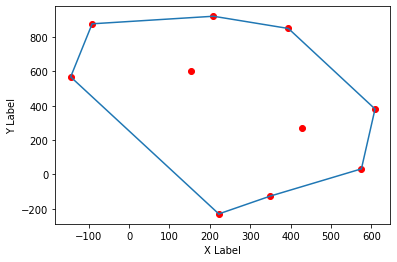

In [366]:
plydata = PlyData.read('points_3.ply')
#print(plydata['vertex'].count)
x = plydata['vertex']['x']
y = plydata['vertex']['y']

points = []
i = 0
for point in plydata['vertex']:
    points.append({'index': i, 'x':point[0], 'y':point[1]})
    i=i+1

edges = graham_scan(points)
save_ply(edges)

plot_ply(points, edges)